In [2]:
import csv
import os
from typing import Dict, List, Union

import numpy as np
import pandas as pd
from tqdm import tqdm
import math
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoConfig, AutoModel, PreTrainedModel
from ex_params import (
    DATA_AI_PATH,
    DATA_HUMAN_PATH,
    DATASETS,
    DATASETS_PATH,
    STATS_PATH,
    SEED,
    BASELINE_MODELS
)
from ex_utils import get_csv_paths
from models import BaselineClassifier

In [8]:
class DesklibAIDetectionModel(PreTrainedModel):
    config_class = AutoConfig

    def __init__(self, config):
        super().__init__(config)
        # Initialize the base transformer model.
        self.model = AutoModel.from_config(config)
        # Define a classifier head.
        self.classifier = nn.Linear(config.hidden_size, 1)
        # Initialize weights (handled by PreTrainedModel)
        self.init_weights()

    def forward(self, input_ids, attention_mask=None, labels=None):
        # Forward pass through the transformer
        outputs = self.model(input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs[0]
        # Mean pooling
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, dim=1)
        sum_mask = torch.clamp(input_mask_expanded.sum(dim=1), min=1e-9)
        pooled_output = sum_embeddings / sum_mask
        print(last_hidden_state.shape, input_mask_expanded.shape, sum_embeddings.shape, sum_mask.shape, pooled_output.shape)
        # Classifier
        logits = self.classifier(pooled_output)
        loss = None
        if labels is not None:
            loss_fct = nn.BCEWithLogitsLoss()
            loss = loss_fct(logits.view(-1), labels.float())

        output = {"logits": logits}
        if loss is not None:
            output["loss"] = loss
        return output

def predict_single_text(text, model, tokenizer, device, max_len=768, threshold=0.5):
    encoded = tokenizer(
        text,
        padding='max_length',
        truncation=True,
        max_length=max_len,
        return_tensors='pt'
    )
    input_ids = encoded['input_ids'].to(device)
    attention_mask = encoded['attention_mask'].to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs["logits"]
        probability = torch.sigmoid(logits).item()

    label = 1 if probability >= threshold else 0
    return probability, label

In [3]:
tokenizer = AutoTokenizer.from_pretrained("desklib/ai-text-detector-v1.01")
model = AutoModel.from_pretrained("desklib/ai-text-detector-v1.01")

tokenizer_config.json:   0%|          | 0.00/1.31k [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/8.66M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/286 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/890 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.74G [00:00<?, ?B/s]

Some weights of DebertaV2Model were not initialized from the model checkpoint at desklib/ai-text-detector-v1.01 and are newly initialized: ['embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.word_embeddings.weight', 'encoder.LayerNorm.bias', 'encoder.LayerNorm.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.self.key_proj.bias', 'encoder.layer.0.attention.self.key_proj.weight', 'encoder.layer.0.attention.self.query_proj.bias', 'encoder.layer.0.attention.self.query_proj.weight', 'encoder.layer.0.attention.self.value_proj.bias', 'encoder.layer.0.attention.self.value_proj.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.0.output.LayerNorm.weight', 'encoder.layer.0.output.dense.bias'

In [9]:
    # --- Model and Tokenizer Directory ---
    model_directory = "desklib/ai-text-detector-v1.01"

    # --- Load tokenizer and model ---
    tokenizer = AutoTokenizer.from_pretrained(model_directory)
    model = DesklibAIDetectionModel.from_pretrained(model_directory)

    # --- Set up device ---
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

DesklibAIDetectionModel(
  (model): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 1024, padding_idx=0)
      (LayerNorm): LayerNorm((1024,), eps=1e-07, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-23): 24 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (key_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (value_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (pos_dropout): Dropout(p=0.1, inplace=False)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNor

In [10]:


# --- Example Input text ---
text_ai = "AI detection refers to the process of identifying whether a given piece of content, such as text, images, or audio, has been generated by artificial intelligence. This is achieved using various machine learning techniques, including perplexity analysis, entropy measurements, linguistic pattern recognition, and neural network classifiers trained on human and AI-generated data. Advanced AI detection tools assess writing style, coherence, and statistical properties to determine the likelihood of AI involvement. These tools are widely used in academia, journalism, and content moderation to ensure originality, prevent misinformation, and maintain ethical standards. As AI-generated content becomes increasingly sophisticated, AI detection methods continue to evolve, integrating deep learning models and ensemble techniques for improved accuracy."
text_human = "It is estimated that a major part of the content in the internet will be generated by AI / LLMs by 2025. This leads to a lot of misinformation and credibility related issues. That is why if is important to have accurate tools to identify if a content is AI generated or human written"

# --- Run prediction ---
probability, predicted_label = predict_single_text(text_ai, model, tokenizer, device)
print(f"Probability of being AI generated: {probability:.4f}")
print(f"Predicted label: {'AI Generated' if predicted_label == 1 else 'Not AI Generated'}")

probability, predicted_label = predict_single_text(text_human, model, tokenizer, device)
print(f"Probability of being AI generated: {probability:.4f}")
print(f"Predicted label: {'AI Generated' if predicted_label == 1 else 'Not AI Generated'}")



torch.Size([1, 768, 1024]) torch.Size([1, 768, 1024]) torch.Size([1, 1024]) torch.Size([1, 1024]) torch.Size([1, 1024])
Probability of being AI generated: 0.9974
Predicted label: AI Generated
torch.Size([1, 768, 1024]) torch.Size([1, 768, 1024]) torch.Size([1, 1024]) torch.Size([1, 1024]) torch.Size([1, 1024])
Probability of being AI generated: 0.4245
Predicted label: Not AI Generated


In [11]:
def predict_multiple_texts(texts, model, tokenizer, device, max_len=768, threshold=0.5):
    # Tokenize all texts
    encoded = tokenizer(
        texts,
        padding='max_length',
        truncation=True,
        max_length=max_len,
        return_tensors='pt'
    )

    input_ids = encoded['input_ids'].to(device)
    attention_mask = encoded['attention_mask'].to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs["logits"]
        probabilities = torch.sigmoid(logits).squeeze(-1)  # Shape: [batch_size]
        labels = (probabilities >= threshold).long()

    # Convert to Python lists for easier processing outside
    return probabilities.cpu().tolist(), labels.cpu().tolist()


In [14]:
texts = [
    text_ai,
    text_human,
    text_ai,
    text_human,
    "test"
]

probabilities, predictions = predict_multiple_texts(texts, model, tokenizer, device)
for text, prob, label in zip(texts, probabilities, predictions):
    print(f"Text: {text}\nProbability: {prob:.4f}, Predicted Label: {label}\n")


torch.Size([5, 768, 1024]) torch.Size([5, 768, 1024]) torch.Size([5, 1024]) torch.Size([5, 1024]) torch.Size([5, 1024])
Text: AI detection refers to the process of identifying whether a given piece of content, such as text, images, or audio, has been generated by artificial intelligence. This is achieved using various machine learning techniques, including perplexity analysis, entropy measurements, linguistic pattern recognition, and neural network classifiers trained on human and AI-generated data. Advanced AI detection tools assess writing style, coherence, and statistical properties to determine the likelihood of AI involvement. These tools are widely used in academia, journalism, and content moderation to ensure originality, prevent misinformation, and maintain ethical standards. As AI-generated content becomes increasingly sophisticated, AI detection methods continue to evolve, integrating deep learning models and ensemble techniques for improved accuracy.
Probability: 0.9974, Pre

In [30]:
df1 = pd.read_csv(TRAINING_HISTORY_PATH + "baseline/training_history_baseline_large_master-mini.csv")
df2 = pd.read_csv(TRAINING_HISTORY_PATH + "baseline/training_history_baseline_large_encoder_master-mini.csv")
df3 = pd.read_csv(TRAINING_HISTORY_PATH + "baseline/training_history_baseline_large_encoder_withtrick_master-mini.csv")
df4 = pd.read_csv(TRAINING_HISTORY_PATH + "baseline/training_history_baseline_large_notrick_master-mini.csv")
df1.head()

,epoch,train_loss,val_loss,val_accuracy,val_balanced_accuracy,val_precision,val_recall,val_f1,val_auc
0,1,0.576092,0.572765,0.806505,0.803091,0.755626,0.921991,0.830560,0.835025
1,2,0.370584,0.390808,0.925099,0.925093,0.928834,0.925272,0.927050,0.978813
2,3,0.232804,0.379045,0.925378,0.924023,0.893082,0.971191,0.930500,0.981306
3,4,0.207310,0.392616,0.938662,0.938721,0.943683,0.936645,0.940151,0.982749
4,5,0.180400,0.346673,0.942717,0.942370,0.935477,0.954466,0.944876,0.986502


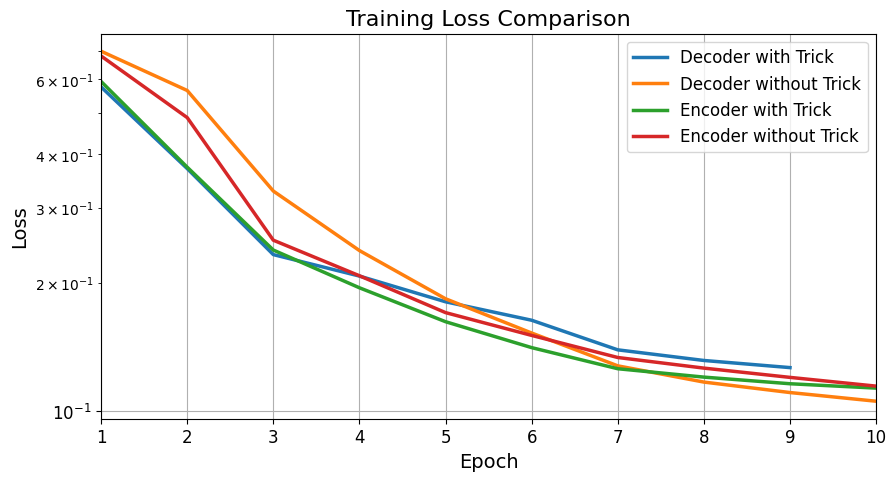

In [36]:
plt.figure(figsize=(10, 5))
plt.title("Training Loss Comparison", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.xlim(1, 10)
plt.plot(df1["epoch"], df1["train_loss"], label="Decoder with Trick", linewidth=2.5)
plt.plot(df4["epoch"], df4["train_loss"], label="Decoder without Trick", linewidth=2.5)
plt.plot(df3["epoch"], df3["train_loss"], label="Encoder with Trick", linewidth=2.5)
plt.plot(df2["epoch"], df2["train_loss"], label="Encoder without Trick", linewidth=2.5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.yscale("log")
plt.grid()
plt.show()